# Plotting Input Files

### 1. Create python environment for notebook

Serto has been developed to be compatible with python versions >= 3.7. It is advised that you use a virtual environment to configure python using python's native virtual environment system (virtualenv) or a package management system like conda.

#### Virtualenv Option

To create a virtual environment using virtualenv:

- Find and install a python compatible python version from online.
- Open the command line application on your platform and change directories to to path where python is to be installed and run the following command. For this application, it makes sense to install the virtual environment in the same folder that contains the notebook (i.e., *.ipynb)

  ```dos
  cd \path\to\new\virtual\environment
  python -m venv virtual_env_name
  ```
- Run the following command to activate the python virtual environment on windows

  ```dos
  .\virtual_env_name\Scripts\activate
  ```

  and unix-like systems, run the following:

  ``` bash
  source  /path/to/new/virtual/environment/virtual_env_name/bin/activate
  ```

#### Conda Option

- Download and install conda/miniconda/conda-forge
- Create python environement using the following command

  ```bash
  conda create --name virtual_env_name python=3.9
  ```

- Activate the virtual environment by running the following command.
  
  ```
  conda activate virtual_env_name
  ```

### 2. Install the dependencies

- The next step in the process is to install the serto package. This can be accomplished using Python Package Index (PyPI) using the following command:

  ```bash
  python -m pip install serto
  ```

  or installing from the source code by cloning the package from Github and installing using the following commands

  ```bash
  git clone https://github.com/USEPA/SERTO.git
  cd SERTO
  python -m pip install .
  ``` 

- Install jupyter lab needed to execute the note book

  ```bash
  pip install jupyterlab
  ```

- It is important that the python environment created is associated with the notebook being executed. For a virtual environment created using virtualenv, this is accomplished using the ipykernel package using the following command:
  
  ```bash
  python -m pip install ipykernel
  python -m ipykernel install --user --name=virtual_env_name
  ```
  
  For conda, use the following command:

  ```
  conda install ipykernel
  ipython kernel install --user --name=virtual_env_name
  ```

### 3. Open and configure python notebook

Python notebooks can be executed in various ways including using jupyter notebook's native interface, various types of integrated development environment (IDE)(e.g., pycharm, Visual Studio Code, etc), or cloud platforms (e.g., Google Collab, Microsoft Azure, Amazon SageMake, Binder, etc.). Here, we provide instructions on how to use the default jupyterlab.

To launch the jupyter notebook via the native interface, execute the following command:

```bash
jupyter lab
```

Select the python virtual envirvonment created as the kernel for executing the notebook by clicking the highlighted section below in jupyter notebook server instance.

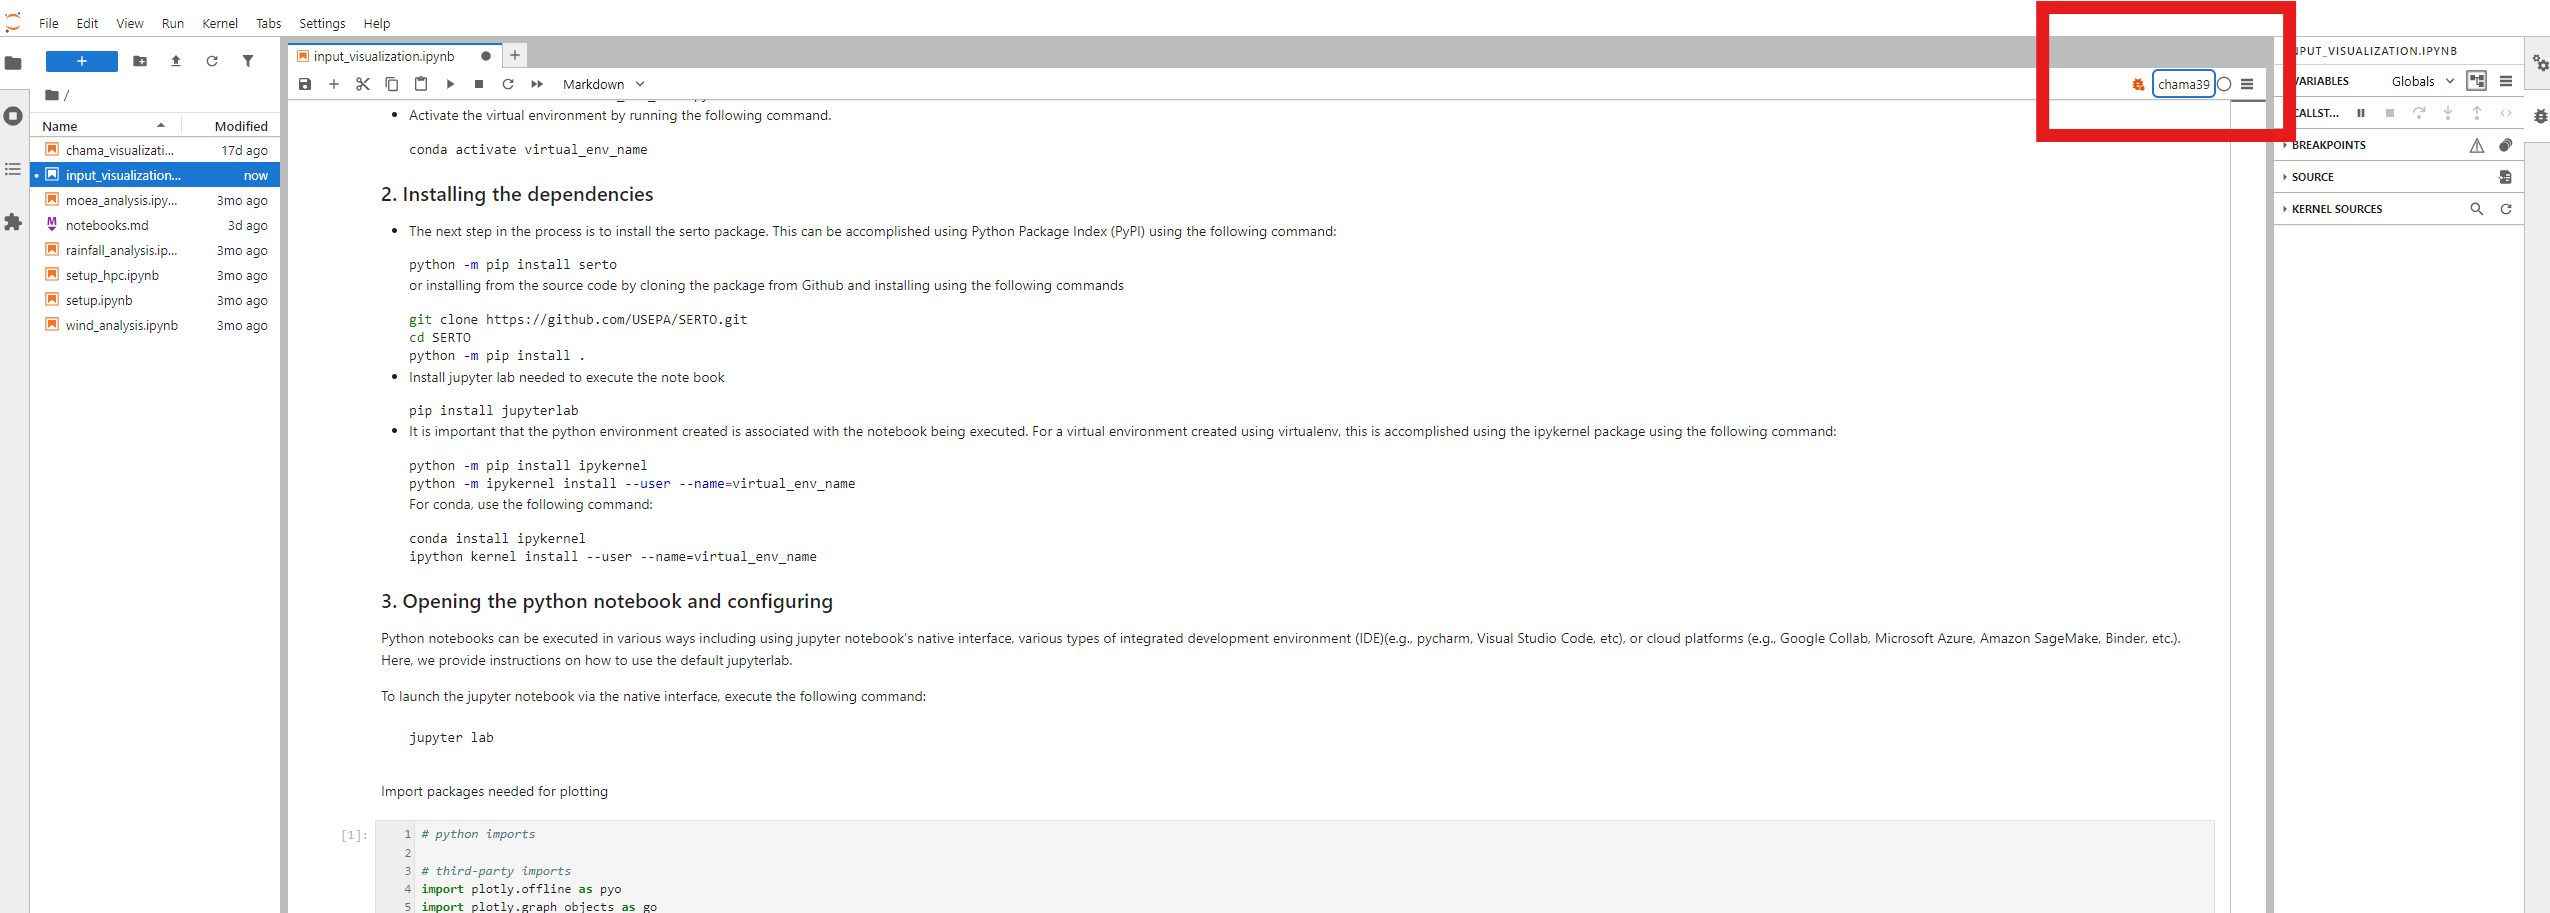

Import packages needed for plotting

In [1]:
# python imports

# third-party imports
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from serto.swmm import SpatialSWMM
from serto.graphics.swmm import SpatialSWMMViz
import contextily as ctx
import matplotlib.pyplot as plt
# local imports

Initialize notebook mode for Plotly to enable interactive plots within the notebook

In [2]:
init_notebook_mode(connected=True)

Read swmm input file into SWMM Spatial

In [4]:
swmm_spatial_model = SpatialSWMM.read_model(
    model_path='../tests/spatialswmm/swmm/test_model.inp',
    crs='EPSG:3089'
)

Plot all elements in the model using interactive plotly figures.

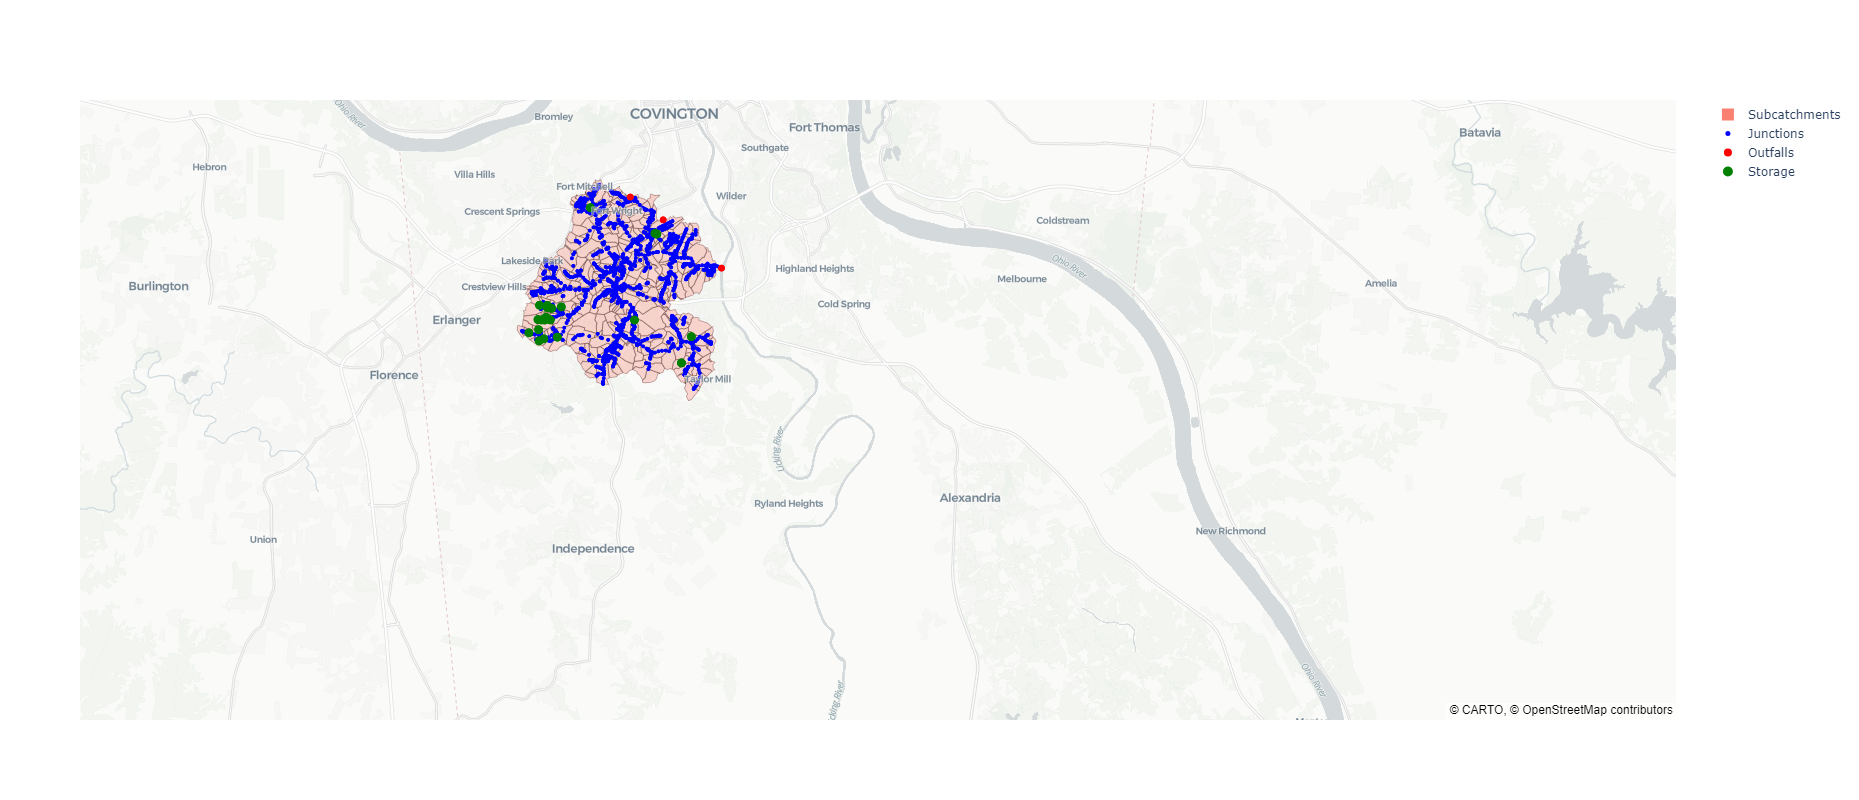

In [5]:
fig = go.Figure()

# Retrieve traces for catchments, links, and nodes
catchment_traces = SpatialSWMMViz.plot_swmm_catchments_plotly(swmm_spatial_model)
link_traces = SpatialSWMMViz.plot_swmm_links_plotly(swmm_spatial_model)
node_traces = SpatialSWMMViz.plot_swmm_nodes_plotly(swmm_spatial_model)

# Center map on centroid of nodes
nodes_centroid = swmm_spatial_model.nodes.dissolve().centroid.to_crs('EPSG:4326')
lon = nodes_centroid.geometry.x[0]
lat = nodes_centroid.geometry.y[0]

for catchment_trace in catchment_traces:
    fig.add_trace(catchment_trace)

for node_trace in node_traces:
    fig.add_trace(node_trace)

fig.update_layout(
    title=f'',
    map_style="carto-positron",
    showlegend=True,
    width=1600,
    height=800,
    map = {
        'center': {'lon': lon, 'lat': lat},
        'zoom': 10
    }
)

fig.show()

Plotly does not handle plolylines with a a lot features efficiently so static plots using matplotlib are sometimes good alternatives.

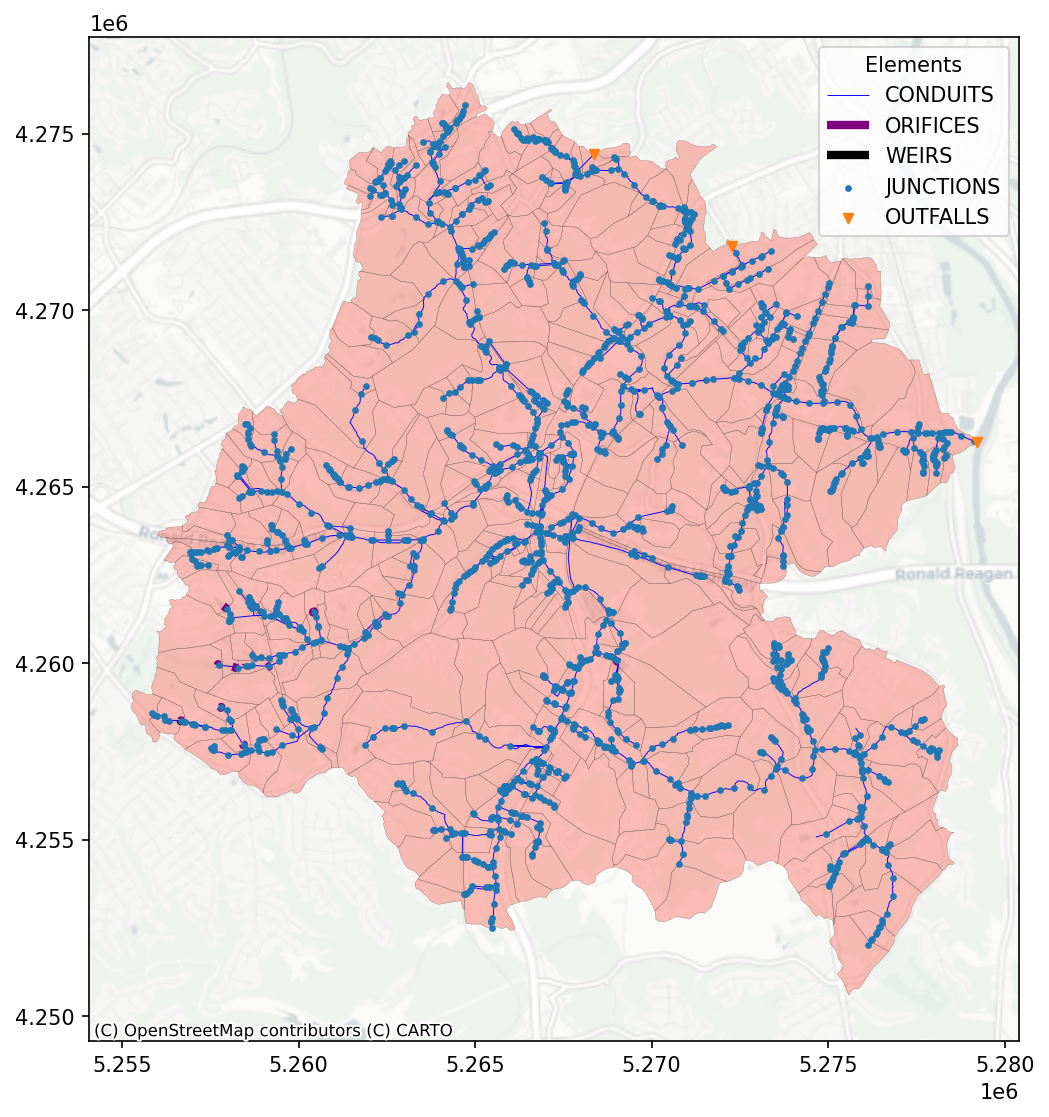

In [6]:
plt.rcParams['figure.figsize'] = [8, 12]
plt.rcParams["figure.dpi"] = 150
ax = swmm_spatial_model.subcatchments.plot(linewidth=0.15, edgecolor='black', facecolor='salmon', alpha=0.5, zorder=1)

link_styles = {
    'CONDUITS': 'solid',
    'PUMPS': 'dashed',
    'ORIFICES': 'dashdot',
    'WEIRS': 'dotted',
}

link_markers = {
    'CONDUITS': None,
    'PUMPS': '1',
    'ORIFICES': 'o',
    'WEIRS': '1',
}

line_colors = {
    'CONDUITS': 'blue',
    'PUMPS': 'red',
    'ORIFICES': 'purple',
    'WEIRS': 'black',
}

line_widths = {
    'CONDUITS': 0.45,
    'PUMPS': 4,
    'ORIFICES': 4,
    'WEIRS': 4,
}

for link_type, linestyle in link_styles.items():

    filtered_links = swmm_spatial_model.links[swmm_spatial_model.links['LinkType'] == link_type]

    if not filtered_links.empty:
        ax = filtered_links.plot(
            ax=ax, 
            linewidth=line_widths[link_type],
            color=line_colors[link_type],
            markersize=10,
            label=link_type,
            zorder=2,
            capstyle='butt',
        )

node_markers = {
    'JUNCTIONS': '.',
    'OUTFALLS': 'v',
    'STORAGES': 's',
    'DIVIDERS': 'o',
}

for node_type, marker in node_markers.items():
    filtered_nodes = swmm_spatial_model.nodes[swmm_spatial_model.nodes['NodeType'] == node_type]
    if not filtered_nodes.empty:
        ax = filtered_nodes.plot(
            ax=ax, 
            marker=marker, 
            markersize=20,
            label=node_type,
            zorder = 3,
        )
plt.legend(title='Elements', loc='upper right')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,  crs=swmm_spatial_model._crs)